# BERTopic

## Data Loading + Preprocessing

In [ ]:
!pip install sentence_transformers umap bertopic transformers kaleido

In [1]:
import warnings

# import hdbscan

warnings.filterwarnings('ignore')

In [6]:
DATA_FOLDER = '../data/'
VARIABLE_FOLDER = '../variables/'
FIGURE_FOLDER = '../reports/'

In [4]:
import pandas as pd
import numpy as np
import os

In [4]:
df = pd.read_csv('tweets.csv')

In [5]:
df = df.dropna()

In [6]:
timestamps = df.date.to_list()
classes = df['query'].to_list()
# texts_list = df.content.to_list()

In [7]:
texts_list = [str(text) for text in df.content.tolist()]  # Convert to string

## Topic Modeling

In [8]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedding_model.encode(texts_list, show_progress_bar=True)

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

In [9]:
import pickle

with open("tweets_embeddings.pkl", "wb") as file:
    pickle.dump(embeddings, file)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = list(stopwords.words('english'))
vectorizer_model = CountVectorizer(ngram_range=(1, 1), stop_words=stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
from umap import UMAP
from sklearn.cluster import SpectralClustering

umap_model = UMAP(n_neighbors=100, n_components=5, min_dist=0.1, metric='cosine', random_state=42)
cluster_model = SpectralClustering(n_clusters=30, random_state=42)

from bertopic.vectorizers import ClassTfidfTransformer

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

In [12]:
from bertopic import BERTopic

topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=cluster_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    top_n_words=5,
    language='english',
    calculate_probabilities=False,
    verbose=True
)

topics, _ = topic_model.fit_transform(texts_list, embeddings)

2023-07-31 01:01:48,685 - BERTopic - Reduced dimensionality
2023-07-31 01:01:52,707 - BERTopic - Clustered reduced embeddings


In [13]:
topic_labels = [str(i + 1) + ' : ' + j for i, j in enumerate(
    topic_model.generate_topic_labels(nr_words=3, topic_prefix=False, word_length=10, separator=", "))]
topic_model.set_topic_labels(topic_labels)

https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#visualize-documents

In [14]:
freq = topic_model.get_topic_info()
# freq.head(10)

In [15]:
num_topics = freq.shape[0]  #num_topics (including -1 for outliers)
# print(num_topics)

# Access updated topics
topics = topic_model.topics_

In [16]:
type(topic_model)

bertopic._bertopic.BERTopic

In [12]:
import pickle
import gzip

with gzip.open(os.path.join(VARIABLE_FOLDER, "tweets_topic_model_object_save.gz"), "wb") as file:
    pickle.dump(topic_model, file)

In [18]:
freq.to_csv('tweets_topic_freq.csv')

## Similarity Matrix

In [19]:
topic_embeddings  = topic_model.topic_embeddings_
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(topic_embeddings)
similarity_matrix_df = pd.DataFrame(similarity_matrix)
similarity_matrix_df.columns = topic_model.get_topic_info()['CustomName']
similarity_matrix_df.index = topic_model.get_topic_info()['CustomName']
print(similarity_matrix_df.shape)

(30, 30)


In [20]:
# similarity_matrix_df.set_index(topic_model.get_topic_info()['Name'])
similarity_matrix_df.to_csv('tweets_distance.csv')

## Prompts

In [21]:
documents = freq['Representative_Docs']
keywords = freq['Representation']
names = freq['Name']

In [22]:
def concatenate_as_bulleted_list(strings):
    bullet_list = "\n".join(f"• {s[:1000]}" for s in strings)
    return bullet_list

prompts = []
for i in range(len(documents)):
    document_list = concatenate_as_bulleted_list(documents[i])
    keyword_list = concatenate_as_bulleted_list(keywords[i])
    prompt = """
    I have a topic that contains the following sentences:
    [DOCUMENTS]

    The topic is described by the following keywords:
    [KEYWORDS]
    """
    prompt = prompt.replace("[DOCUMENTS]", document_list)
    prompt = prompt.replace("[KEYWORDS]", keyword_list)

    # print(prompt)

    prompts.append(prompt)

In [23]:
from transformers import pipeline

def generate_answer(question, context):
    nlp = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad", tokenizer="distilbert-base-uncased")
    result = nlp(question=question, context=context)
    answer = result["answer"]
    return answer

In [24]:
question = 'What label would you give to the topic?'

# for prompt in prompts:
    # answer = generate_answer(question, prompt)

## Hierarchical Topic Modeling (HTM)
https://maartengr.github.io/BERTopic/api/plotting/hierarchy.html
https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#hierarchical-labels

In [25]:
# hierarchical_topics = topic_model.hierarchical_topics(texts_list)

In [26]:
# fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, orientation='bottom', custom_labels=True)
# fig.show()
# fig.write_image(FIGURE_FOLDER + 'figures/Hierarchical Clustering.png')

## Topics per Query/Class
https://maartengr.github.io/BERTopic/api/plotting/topics_per_class.html
https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#visualize-topics-per-class

In [27]:
topics_per_class = topic_model.topics_per_class(texts_list, classes=classes)

21it [00:00, 67.08it/s]


In [28]:
fig = topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=10, custom_labels=True)
fig.update_layout(
    width=800,
    height=400,
    margin=dict(l=50, r=50, t=50, b=100)
)
fig.show()
# fig.write_image(FIGURE_FOLDER + 'figures/Classes per Top 10 Topics.png')
fig.write_html('Tweets Classes per Top 10 Topics.html')

## Other Visualization

https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#visualize-topics-per-class

In [29]:
fig = topic_model.visualize_barchart(custom_labels=True)
fig.show()
fig.write_image('Tweets Topic Word Scores.png')

In [30]:
# fig = topic_model.visualize_heatmap(custom_labels=True)
# fig.show()
# fig.write_image(FIGURE_FOLDER + 'figures/Similarity Matrix.png')

## Find Groupings

In [31]:
from sklearn.preprocessing import MinMaxScaler as mms

# from umap import UMAP

umap_model_embed_vis = UMAP(n_neighbors=5, n_components=2, min_dist=0, metric='cosine', random_state=42)
umap_model_embed = UMAP(n_neighbors=5, n_components=3, min_dist=0, metric='cosine', random_state=42)

c_tf_idf_mms = mms().fit_transform(topic_model.c_tf_idf_.toarray())
c_tf_idf_embed_vis = umap_model_embed_vis.fit_transform(c_tf_idf_mms)
c_tf_idf_embed = umap_model_embed.fit_transform(c_tf_idf_mms)

In [32]:
with open("tweets_c_tf_idf_mms.pkl", "wb") as file:
    pickle.dump(c_tf_idf_mms, file)

with open("tweets_c_tf_idf_embed_vis.pkl", "wb") as file:
    pickle.dump(c_tf_idf_embed_vis, file)

with open("tweets_c_tf_idf_embed.pkl", "wb") as file:
    pickle.dump(c_tf_idf_embed, file)

In [46]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import SpectralClustering
# from matplotlib import colormaps as cm
import seaborn as sns
import matplotlib.pyplot as plt


def find_clustering_scores(c_tf_idf_embed, llim=3, ulim=25):
    ss = []
    db = []

    cluster_arr = np.arange(llim, ulim)
    for n_clusters in cluster_arr:
        clusters = SpectralClustering(n_clusters=n_clusters, random_state=42).fit_predict(c_tf_idf_embed)
        ss.append(silhouette_score(c_tf_idf_embed, clusters))
        db.append(davies_bouldin_score(c_tf_idf_embed, clusters))

    with sns.plotting_context('notebook'):
        sns.set_style('ticks')
        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(5, 5))
        sns.lineplot(x=cluster_arr, y=ss, ax=ax[0])
        sns.lineplot(x=cluster_arr, y=db, ax=ax[1])

        ax[0].set_ylabel('Silhouette Score')
        ax[1].set_ylabel('Davies-Bouldin Score')

        ax[1].set_xlabel('Number of Clusters')

        fig.suptitle('Clustering Performance', fontsize=15, y=0.95)

        fig.savefig('TweetsClusteringPerformance.svg', bbox_inches='tight', transparent=True)

    ideal_n_clusters = cluster_arr[np.argmax(ss)]

    print("top silhouette score: {0:0.3f} for at n_clusters {1}".format(np.max(ss), cluster_arr[np.argmax(ss)]))
    # print("top davies-bouldin score: {0:0.3f} for at n_clusters {1}".format(np.min(db), cluster_arr[np.argmin(db)]))

    if cluster_arr[np.argmax(ss)] == cluster_arr[np.argmin(db)]:
        print('match!')

    return ideal_n_clusters
    # return cluster_arr[np.argmax(ss)]

top silhouette score: 0.609 for at n_clusters 3


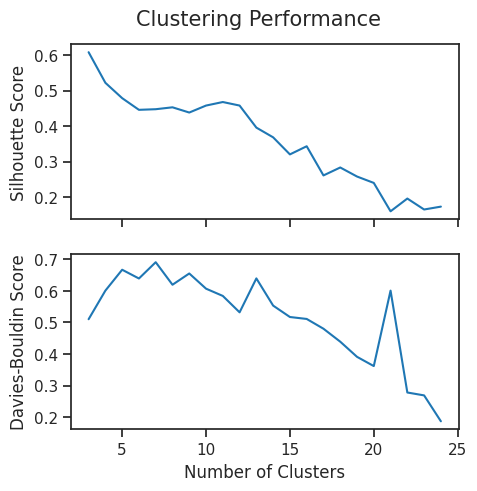

In [47]:
ideal_n_clusters = find_clustering_scores(c_tf_idf_embed)
c_tf_idf_embed_clust = SpectralClustering(n_clusters=ideal_n_clusters, random_state=42).fit_predict(c_tf_idf_embed) + 1

In [35]:
with open("tweets_ideal_n_clusters.pkl", "wb") as file:
    pickle.dump(ideal_n_clusters, file)

with open("tweets_c_tf_idf_embed_clust.pkl", "wb") as file:
    pickle.dump(c_tf_idf_embed_clust, file)

In [36]:
# df.shape

In [37]:
# df.loc[9236,:]

In [38]:
# def find_most_common_subreddit_per_cluster(df, topics):
#     subreddits = df['subreddit'].unique()
#     # print(subreddits)
#     subreddit_per_topic = pd.DataFrame(index=np.arange(0, np.max(topics) + 1), columns=subreddits).fillna(0)
#     # print(subreddit_per_topic)
#     # print(set(topics))
#     for i, topic_i in enumerate(topics):
#         # print(i)
#         try:
#             subreddit_i = df.loc[i, 'subreddit']
#             # print(subreddit_i)
#             subreddit_per_topic.loc[topic_i, subreddit_i] += 1
#         except:
#             continue
#     # print(subreddit_per_topic)
#     return [subreddits[subreddit_per_topic.iloc[i].argmax()] for i in np.arange(0, np.max(topics) + 1)]


# def find_number_of_users_subreddit_per_cluster(df, topics, topic_model):
#     topic_np = np.array(topics)
#     base = [df.iloc[np.where(topic_np == i)[0]]['author'].nunique() for i in np.arange(0, np.max(topics) + 1)]
#     return np.array(base) / topic_model.get_topic_info()['Count']


# subreddit_by_cluster = find_most_common_subreddit_per_cluster(df, topics)
# unique_users_by_cluster = find_number_of_users_subreddit_per_cluster(df, topics, topic_model)

In [39]:
# with open("subreddit_by_cluster.pkl", "wb") as file:
#     pickle.dump(subreddit_by_cluster, file)
# #
# with open("unique_users_by_cluster.pkl", "wb") as file:
#     pickle.dump(unique_users_by_cluster, file)

In [1]:
import pickle
pickle.HIGHEST_PROTOCOL

5

In [40]:
df['Topic'] = topics
kw = ['"' + '", "'.join([i[0] for i in topic_model.get_topic(j)]) + '"' for j in
      range(np.min(np.unique(topics)), np.max(np.unique(topics))+1)]
# print(len(kw))
df['Group'] = [c_tf_idf_embed_clust[i] for i in df['Topic']]
df['Keywords'] = [kw[i] for i in df['Topic']]
df['Date_year'] = pd.to_datetime(df['date']).dt.year.astype('int')

In [41]:
df.to_csv('tweets_assigned_topics.csv', index=False)

In [42]:
# Merge the two dataframes based on 'Topic' column
merged_df = pd.merge(df, freq, on='Topic')

# Group topics, topic names, and content by group number
grouped_data = merged_df.groupby('Group').apply(lambda x: {'Topics': x['Topic'].unique().tolist(), 'Topic Names': x['Name'].unique().tolist(), 'Content': x['content'].sample(n=2).tolist()})

In [43]:
grouped_data

Group
1    {'Topics': [18, 22, 24, 6, 25, 13, 3, 27, 29, ...
2    {'Topics': [14, 17, 19, 1, 9, 10, 26, 16, 12, ...
3    {'Topics': [7, 8, 15, 2, 0, 5], 'Topic Names':...
dtype: object

In [44]:
print(type(grouped_data))

<class 'pandas.core.series.Series'>


In [45]:
# Convert Series to DataFrame
topics_by_group_df = pd.DataFrame(grouped_data.values.tolist(), index=grouped_data.index)
topics_by_group_df.columns = ['Topics', 'Topic Names', 'Content']

# Save DataFrame to CSV
topics_by_group_df.to_csv('tweets_topics_by_group.csv', index_label='Group')